<a href="https://colab.research.google.com/github/lblogan14/hands_on_notes/blob/master/Ch15_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

In [0]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

Autoencoders are artificial neural networks capable of learning efficient representa‐
tions of the input data, called *codings*, without any supervision (i.e., the training set is
unlabeled). These codings typically have a much lower dimensionality than the input
data, making autoencoders useful for dimensionality reduction. More
importantly, autoencoders act as powerful feature detectors, and they can be used for
unsupervised pretraining of deep neural networks.
Lastly, they are capable of randomly generating new data that looks very similar to the
training data; this is called a *generative model*. For example, you could train an
autoencoder on pictures of faces, and it would then be able to generate new faces.

#Efficient Data Representations
An autoencoder is always composed of two parts: an *encoder* (or *recognition network*) that converts the inputs to an
internal representation, followed by a *decoder* (or *generative network*) that converts the internal representation to the outputs.

The outputs are often called the *reconstructions* since the autoencoder tries to reconstruct the inputs, and the cost function contains a *reconstruction loss* that penalizes the model when the reconstructions are different from the inputs.

Because the internal representation has a lower dimensionality than the input data, the autoencoder is said to be *undercomplete*. An undercomplete autoencoder cannot trivially copy its inputs to the codings, yet it must find a way to output a copy of its inputs. It is forced to learn the most important features in the input data (and drop the unimportant ones).

#Performing PCA with an Undercomplete Linear Autoencoder
If the autoencoder uses only *linear activations* and the cost function is the *Mean Squared Error* (MSE), then it can be shown that it ends up performing Principal Component Analysis

In [0]:
# build 3D dataset:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [0]:
# normalize the data:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [0]:
# build an Autoencoder
reset_graph()

n_inputs = 3 # 3D inputs
n_hidden = 2 # 2D codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [0]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
  init.run()
  for interation in range(n_iterations):
    training_op.run(feed_dict={X: X_train})
  codings_val = codings.eval(feed_dict={X: X_test})

Text(0,0.5,'$z_2$')

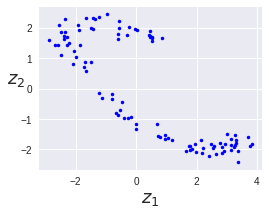

In [7]:
# plot the result
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)

#Stacked Autoencoders
also called *deep autoencoders*, have multiple hidden layers. More layers can help learning more complex codings.

Be careful not to make the autoencoder too powerful. Imagine an encoder so powerful that it just learns to map each input to a single arbitrary number (and the decoder learns the reverse mapping). Obviously such an autoencoder will reconstruct the training data perfectly, but it will not have learned any useful data representation in the process (and it is unlikely to generalize well to new instances).

The architecture of a stacked autoencoder is typically symmetrical with regards to the
central hidden layer (the coding layer).


##TensorFlow Implementation
The following code builds a stacked autoencoder for MNIST, using *He initialization*, the *ELU activation function*, and *$\ell_2$ regularization*.

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders)

Note: since the **tf.layers.dense()** function is incompatible with **tf.contrib.layers.arg_scope()**, we now use python's **functools.partial()** function instead. It makes it easy to create a **my_dense_layer()** function that just calls **tf.layers.dense()** with the desired parameters automatically set.

In [0]:
reset_graph()

from functools import partial

n_inputs = 28 * 28 # for MNIST
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense, 
                        activation = tf.nn.elu,
                        kernel_initializer=he_init,
                        kernel_regularizer = l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

For autoencoders, there is no labels. This is unsupervised training,

In [14]:
import sys

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = mnist.train.num_examples // batch_size
    for iteration in range(n_batches):
      print('\r{}%'.format(100*iteration // n_batches), end='')
      sys.stdout.flush()
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      sess.run(training_op, feed_dict={X: X_batch})
    loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
    print('\r{}'.format(epoch), 'Train MSE:', loss_train)
    saver.save(sess, './my_model_all_layers.ckpt')

0 Train MSE: 0.021799
1 Train MSE: 0.011398658
2 Train MSE: 0.010222745
3 Train MSE: 0.009901829
4 Train MSE: 0.010377057


This function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction:

In [0]:
def show_reconstructed_digits(X, outputs, model_path=None, n_test_digits=2):
  with tf.Session() as sess:
    if model_path:
      saver.restore(sess, model_path)
    X_test = mnist.test.images[:n_test_digits]
    outputs_val = outputs.eval(feed_dict={X: X_test})
    
  plt.figure(figsize=(8, 3*n_test_digits))
  for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index*2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index*2 + 2)
    plot_image(X_test[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


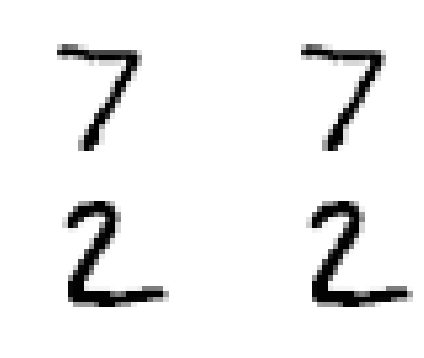

In [18]:
show_reconstructed_digits(X, outputs, './my_model_all_layers.ckpt')

##Tying Weights
When an autoencoder is neatly symmetrical, a common technique is to *tie the weights* of the decoder layers to the weights of the encoder layers. This halves the number of weights in the model, speeding up training and limiting the risk of overfitting. 

Specifically, if the autoencoder has a total of $N$ layers (not counting the input layer), and $W_L$ represents the connection weights of the $L^{th}$ layer (e.g., layer 1 is the first hidden layer, layer $\frac{N}{2}$ is the coding layer, and layer $N$ is the output layer), then the decoder layer weights can be defined simply as: $W_{N–L+1} = W_L^T$ (with $L = 1, 2, ⋯, \frac{N}{2}$).

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [0]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.015066836
1 Train MSE: 0.016488565
2 Train MSE: 0.017375804
3 Train MSE: 0.016878227
4 Train MSE: 0.015587643


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


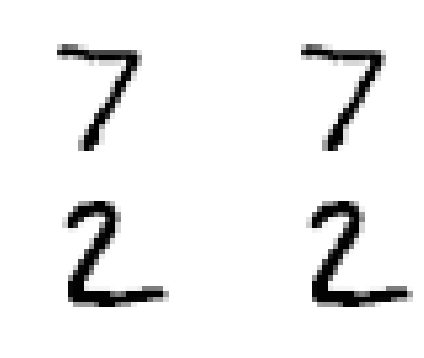

In [22]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

##Training One Autoencoder at a Time
Rather than training the whole stacked autoencoder in one go like we just did, it is
often much faster to train one shallow autoencoder at a time, then stack all of them
into a single stacked autoencoder

###Training One Autoencoder at a Time in Multiple Graphs
There are many ways to train one Autoencoder at a time. The first approach is to train each Autoencoder using a different graph, then we create the Stacked Autoencoder by simply initializing it with the weights and biases copied from these Autoencoders.

Let's create a function that will train one autoencoder and return the transformed training set (i.e., the output of the hidden layer) and the model parameters.

In [0]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                     learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                     hidden_activation = tf.nn.elu,
                     output_activation = tf.nn.elu):
  graph = tf.Graph()
  with graph.as_default():
    tf.set_random_seed(seed)
  
    n_inputs = X_train.shape[1]
  
    X = tf.placeholder(tf.float32, shape=[None, n_inputs])
  
    my_dense_layer = partial(tf.layers.dense,
                            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))
  
    hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name='hidden')
    outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name='outputs')
  
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
  
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([reconstruction_loss] + reg_losses)
  
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
  
    init = tf.global_variables_initializer()
    
  with tf.Session(graph=graph) as sess:
    init.run()
    for epoch in range(n_epochs):
      n_batches = len(X_train) // batch_size
      for iteration in range(n_batches):
        print("\r{}%".format(100 * iteration // n_batches), end="")
        sys.stdout.flush()
        indices = rnd.permutation(len(X_train))[:batch_size]
        X_batch = X_train[indices]
        sess.run(training_op, feed_dict={X: X_batch})
      loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
      print("\r{}".format(epoch), "Train MSE:", loss_train)
    params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
    hidden_val = hidden.eval(feed_dict={X: X_train})
    return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

Now let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

In [28]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE: 0.018517736
1 Train MSE: 0.018682605
2 Train MSE: 0.018467626
3 Train MSE: 0.019231625
0 Train MSE: 0.004236107
1 Train MSE: 0.0048326766
2 Train MSE: 0.004668746
3 Train MSE: 0.0044039064


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [0]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

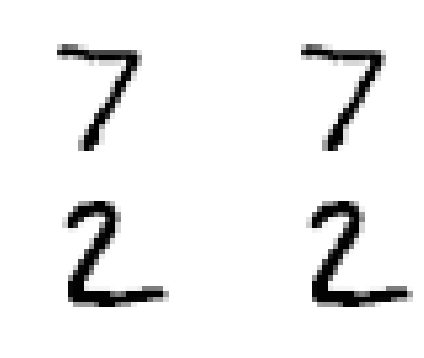

In [30]:
show_reconstructed_digits(X, outputs)

###Training One Autoencoder at a Time in a Single Graph
Another approach is to use a single graph. To do this, we create the graph for the full Stacked Autoencoder, but then we also add operations to train each Autoencoder independently: phase 1 trains the bottom and top layer (ie. the first Autoencoder) and phase 2 trains the two middle layers (ie. the second Autoencoder).

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.007406838
1 Train MSE: 0.0078287525
2 Train MSE: 0.0077280574
3 Train MSE: 0.0074089756
Training phase #2
0 Train MSE: 0.30220637
1 Train MSE: 0.006056244
2 Train MSE: 0.002984179
3 Train MSE: 0.0024322327
Test MSE: 0.009801973


####Cache the frozen layer outputs

In [35]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.0075382274
1 Train MSE: 0.0077546337
2 Train MSE: 0.007343643
3 Train MSE: 0.007837738
Training phase #2
0 Train MSE: 0.16329405
1 Train MSE: 0.004250071
2 Train MSE: 0.0023960955
3 Train MSE: 0.0020165795
Test MSE: 0.009769421


##Visualizing the Reconstructions

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


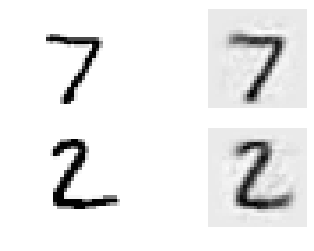

In [36]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt")
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

##Visualizing Features
Arguably the simplest technique is to
consider each neuron in every hidden layer, and find the training instances that activate it the most. This is especially useful for the top hidden layers since they oftencapture relatively large features that you can easily spot in a group of training instances that contain them.
However, for lower layers, this technique does not work so well, as the features are smaller and more abstract, so it’s often hard to understand exactly what the neuron is getting all excited about.

Another technique is to create an image where a pixel's intensity corresponds to the weight of the connection to the given neuron, for each neuron in the first hidden layer.

For example, the following code plots the features learned by five neurons in the first hidden layer:

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


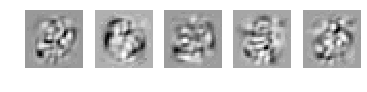

In [37]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

The first four features seem to correspond to small patches, while the fifth feature seems to look for vertical strokes

#Unsupervised Pretraining Using Stacked Autoencoders
If you are tackling a complex supervised task but you do not have a lot of labeled training data, one solution is to find a neural network that performs a similar task, and then reuse its lower layers. This makes it possible to train a high-performance model using only little training data because your neural network won’t have to learn all the low-level features; it will just reuse the feature detectors learned by the existing net.
Similarly, if you have a large dataset but most of it is unlabeled, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual task, and train it using the labeled data.

This situation is actually quite common, because building a large unlabeled dataset is often cheap (e.g., a simple script can download
millions of images off the internet), but labeling them can only be done reliably by humans (e.g., classifying images as cute or not).
Labeling instances is time-consuming and costly, so it is quite common to have only a few thousand labeled instances.

There is nothing special about the TensorFlow implementation: just train an autoencoder using all the training data, then reuse its encoder layers to create a new neuralnetwork

Let's create a small neural network for MNIST classification:

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

Regular training (without pretraining):

In [39]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 Train accuracy: 0.97333336 Test accuracy: 0.9334
1 Train accuracy: 0.98 Test accuracy: 0.936
2 Train accuracy: 0.97333336 Test accuracy: 0.9382
3 Train accuracy: 0.9866667 Test accuracy: 0.9493


Now reusing the first two layers of the autoencoder we pretrained:

In [40]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

# Freeze layers 1 and 2 (optional), if you don't have much labeled training data
#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
0 Train accuracy: 0.97333336	Test accuracy: 0.9315
1 Train accuracy: 0.9866667	Test accuracy: 0.9426
2 Train accuracy: 0.97333336	Test accuracy: 0.9417
3 Train accuracy: 0.96	Test accuracy: 0.9492


#Denoising Autoencoders
Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. This prevents the autoencoder from trivially copying its inputs to its outputs, so it ends up having to find patterns in the data.

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched off inputs, just like in dropout.

##TensorFlow Implementation

###Using Gaussian noise,

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

Since the shape of **X** is only partially defined during the construction phase, we cannot know in advance the shape of the noise that
we must add to **X**. We cannot call **X.get_shape()** because this would just return the partially defined shape of **X ([None, n_inputs])**, and **random_normal()** expects a fully defined shape so it would raise an exception. Instead, we call **tf.shape(X)**, which creates an operation that will return the shape of **X** at runtime, which will be fully defined at that point.

In [0]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                          name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu,
                          name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.044181567
1 Train MSE: 0.04296087
2 Train MSE: 0.04233508
3 Train MSE: 0.04071373
4 Train MSE: 0.040283825
5 Train MSE: 0.038643315
6 Train MSE: 0.04008824
7 Train MSE: 0.042506676
8 Train MSE: 0.039631158
9 Train MSE: 0.040578663


###Using dropout,

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [0]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                          name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu,
                          name="hidden3")
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [49]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.029614283
1 Train MSE: 0.02841155
2 Train MSE: 0.025273515
3 Train MSE: 0.025758337
4 Train MSE: 0.025205098
5 Train MSE: 0.025992865
6 Train MSE: 0.024873488
7 Train MSE: 0.02571089
8 Train MSE: 0.025515543
9 Train MSE: 0.025003806


INFO:tensorflow:Restoring parameters from ./my_model_stacked_denoising_dropout.ckpt


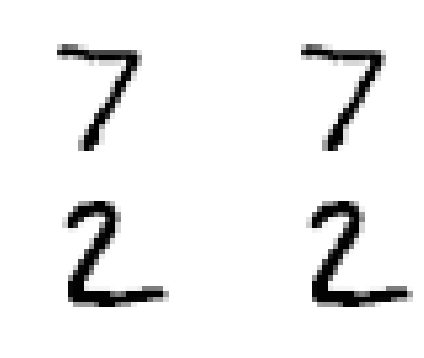

In [50]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

#Sparse Autoencoders
Another kind of constraint that often leads to good feature extraction is sparsity: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result, each neuron in the coding layer typically ends up representing a useful feature.

In order to favor sparse models, we must first measure the actual sparsity of the coding layer at each training iteration. We do so by computing the average activation of each neuron in the coding layer, over the whole training batch. The batch size must not be too small, or else the mean will not be accurate.

Once we have the mean activation per neuron, we want to penalize the neurons that are too active by adding a sparsity loss to the cost function.

One approach could be simply adding the squared error to the cost function, but in practice a better approach is to use the Kull‐back-Leibler divergence, which has much stronger gradients than the Mean Squared Error,

Given two discrete probability distributions $P$ and $Q$, the KL divergence between these distributions, noted $D_{KL}(P || Q)$, can be computed using

$D_{KL}(P||Q)=\sum\limits_{i}P(i)\log\frac{P(i)}{Q{(i)}}$

T omeasure the divergence between the target probability $p$ that a neuron in the coding layer will activate, and the actual probability $q$,

$D_{KL}(p||q)=p\log\frac{p}{q}+(1-p)\log\frac{1-p}{1-q}$

Once we have computed the sparsity loss for each neuron in the coding layer, we just sum up these losses, and add the result to the cost function.

[0, 1, 0, 0.95]

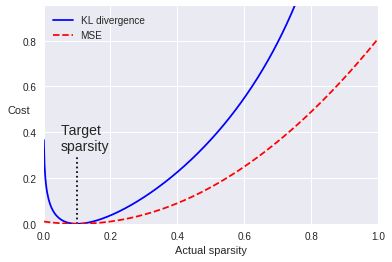

In [51]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

##TensorFlow Implementation
An important detail is the fact that the activations of the coding layer must be between 0 and 1 (but not equal to 0 or 1), or else the KL divergence will return NaN. A simple solution is to use the logistic activation function for the coding layer.

One simple trick can speed up convergence: instead of using the MSE, we can choose a reconstruction loss that will have larger gradients. Cross entropy is often a good choice. To use it, we must normalize the inputs to make them take on values from 0
to 1, and use the logistic activation function in the output layer so the outputs also take on values from 0 to 1. TensorFlow’s **sigmoid_cross_entropy_with_logits()** function takes care of efficiently applying the logistic (sigmoid) activation function to
the outputs and computing the cross entropy:

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [0]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# Note that the coding layer must output values from 0 to 1, 
# which is why we use the sigmoid activation function:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)
outputs = tf.layers.dense(hidden1, n_outputs)

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [55]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.13819368 	Sparsity loss: 0.41844344 	Total loss: 0.22188237
1 Train MSE: 0.059182107 	Sparsity loss: 0.010747538 	Total loss: 0.061331615
2 Train MSE: 0.053926278 	Sparsity loss: 0.019957874 	Total loss: 0.057917852
3 Train MSE: 0.04770912 	Sparsity loss: 0.039473213 	Total loss: 0.05560376
4 Train MSE: 0.044837117 	Sparsity loss: 0.011592084 	Total loss: 0.047155533
5 Train MSE: 0.04043855 	Sparsity loss: 0.092469595 	Total loss: 0.05893247
6 Train MSE: 0.038863152 	Sparsity loss: 0.045811433 	Total loss: 0.04802544
7 Train MSE: 0.037865393 	Sparsity loss: 0.07498014 	Total loss: 0.052861422
8 Train MSE: 0.033119526 	Sparsity loss: 0.02032249 	Total loss: 0.037184022
9 Train MSE: 0.031446654 	Sparsity loss: 0.09567106 	Total loss: 0.050580867
10 Train MSE: 0.027395861 	Sparsity loss: 0.065706566 	Total loss: 0.040537175
11 Train MSE: 0.024732923 	Sparsity loss: 0.088891506 	Total loss: 0.042511225
12 Train MSE: 0.023365393 	Sparsity loss: 0.05766259 	Total loss: 0.03489

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


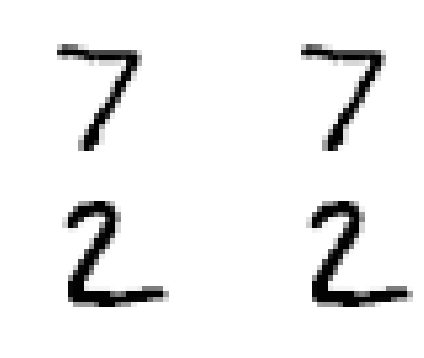

In [56]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

To speed up training, you can normalize the inputs between 0 and 1, and use the cross entropy instead of the MSE for the cost function:

In [0]:
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

#Variational Autoencoders
* They are *probabilistic autoencoders*, meaning that their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness only during training).
* Most importantly, they are *generative autoencoders*, meaning that they can generate new instances that look like they were sampled from the training set.

Although the inputs may have a very convoluted distribution, a variational autoencoder tends to produce codings that look as though
they were sampled from a simple Gaussian distribution:

During training, the cost function pushes the codings to gradually migrate within the coding space (also called the latent space) to occupy a roughly (hyper)spherical region that looks like a cloud of Gaussian points.

The cost function is composed of two parts. The first is the usual reconstruction loss that pushes the autoencoder to reproduce its inputs. The second is the latent loss that pushes the autoencoder to have codings that look as though they were sampled from a simple Gaussian distribution, for which we use the KL divergence between the target distribution (the Gaussian distribution) and the actual distribution of the codings.

One common variant is to train the encoder to output $\gamma = \log(\sigma^2)$ rather than $\sigma$. Wherever we need σ we can just compute $\sigma = \exp(\frac{\gamma}{2})$. This makes it a bit easier for the encoder to capture sigmas of different scales, and thus it helps speed up convergence.

In [0]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [0]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [0]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [60]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 32018.078 	Reconstruction loss: 24817.87 	Latent loss: 7200.21
1 Train total loss: 26572.348 	Reconstruction loss: 21785.473 	Latent loss: 4786.876
2 Train total loss: 28557.684 	Reconstruction loss: 23722.07 	Latent loss: 4835.6123
3 Train total loss: 25480.422 	Reconstruction loss: 21642.148 	Latent loss: 3838.274
4 Train total loss: 23846.242 	Reconstruction loss: 20467.604 	Latent loss: 3378.6387
5 Train total loss: 20197.898 	Reconstruction loss: 17304.535 	Latent loss: 2893.3628
6 Train total loss: 18646.316 	Reconstruction loss: 15848.817 	Latent loss: 2797.4993
7 Train total loss: 17737.434 	Reconstruction loss: 14589.299 	Latent loss: 3148.1343
8 Train total loss: 16592.584 	Reconstruction loss: 13546.54 	Latent loss: 3046.0444
9 Train total loss: 16975.775 	Reconstruction loss: 13855.01 	Latent loss: 3120.766
10 Train total loss: 16530.463 	Reconstruction loss: 13376.461 	Latent loss: 3154.0015
11 Train total loss: 16062.183 	Reconstruction loss: 13024.493

In [0]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

##Generating Digits
Now let’s use this variational autoencoder to generate images that look like handwritten digits. All we need to do is train the model, then sample random codings from a Gaussian distribution and decode them.

In [62]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 17792.648 	Reconstruction loss: 14123.008 	Latent loss: 3669.6396
1 Train total loss: 17332.248 	Reconstruction loss: 13560.002 	Latent loss: 3772.2466
2 Train total loss: 16350.773 	Reconstruction loss: 12579.293 	Latent loss: 3771.4807
3 Train total loss: 16581.332 	Reconstruction loss: 12810.544 	Latent loss: 3770.787
4 Train total loss: 16223.904 	Reconstruction loss: 12450.061 	Latent loss: 3773.8433
5 Train total loss: 15628.15 	Reconstruction loss: 11819.644 	Latent loss: 3808.5073
6 Train total loss: 16080.885 	Reconstruction loss: 12179.654 	Latent loss: 3901.2305
7 Train total loss: 15772.816 	Reconstruction loss: 12021.295 	Latent loss: 3751.521
8 Train total loss: 16276.459 	Reconstruction loss: 12404.661 	Latent loss: 3871.7979
9 Train total loss: 15589.61 	Reconstruction loss: 11740.604 	Latent loss: 3849.0066
10 Train total loss: 15931.251 	Reconstruction loss: 12031.271 	Latent loss: 3899.9795
11 Train total loss: 16112.755 	Reconstruction loss: 1223

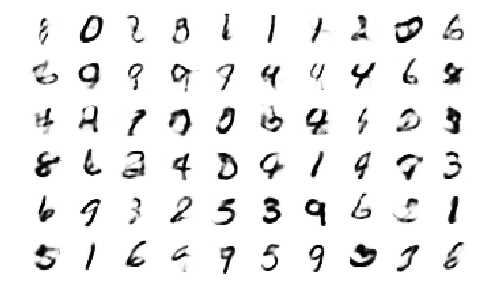

In [63]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

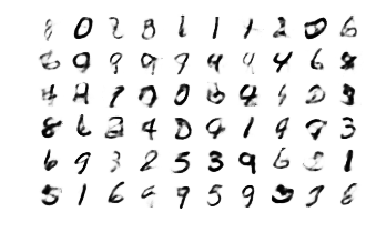

In [64]:
n_rows = 6
n_cols = 10
plot_multiple_images(outputs_val.reshape(-1, 28, 28), n_rows, n_cols)

Note that the latent loss is computed differently in this second variant:

In [0]:
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

##Encode & Decode

Encode:

In [65]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Decode:

In [66]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


Let's plot the reconstructions:

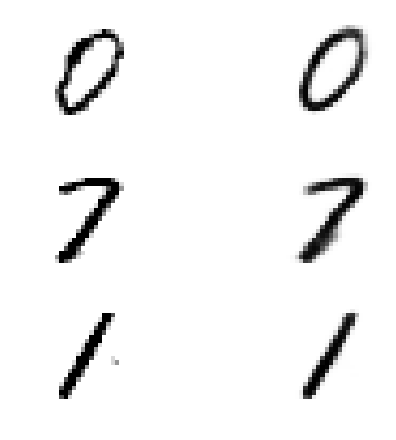

In [67]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])

##Interpolate Digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


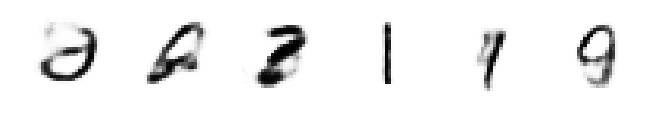

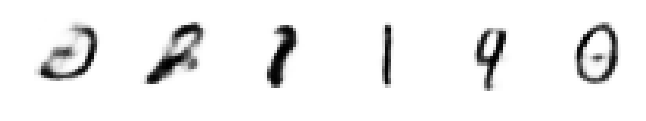

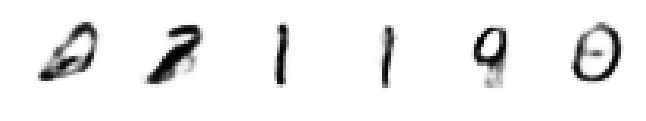

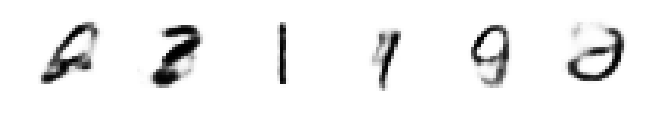

In [68]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])